In [1]:
#!pip install nltk
#!pip install scikit-learn

## 1. Import and observe dataset

In [2]:
# Import modules
import numpy as np
import pandas as pd
import nltk
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')
# Set seed for reproducibility
np.random.seed(5)

# Read in IMDb and Wikipedia movie data (both in same file)
movies_df = pd.read_csv('datasets/movies.csv')

print("Number of movies loaded: %s " % (len(movies_df)))

# Display the data
movies_df

Number of movies loaded: 100 


[nltk_data] Downloading package punkt to /home/jhonjc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."
...,...,...,...,...,...
95,95,Rebel Without a Cause,[u' Drama'],\n\n\n\nJim Stark is in police custody.\n\n \...,Shortly after moving to Los Angeles with his p...
96,96,Rear Window,"[u' Mystery', u' Thriller']",\n\n\n\nJames Stewart as L.B. Jefferies\n\n \...,"L.B. ""Jeff"" Jeffries (James Stewart) recuperat..."
97,97,The Third Man,"[u' Film-Noir', u' Mystery', u' Thriller']",\n\n\n\nSocial network mapping all major chara...,"Sights of Vienna, Austria, flash across the sc..."
98,98,North by Northwest,"[u' Mystery', u' Thriller']",Advertising executive Roger O. Thornhill is mi...,"At the end of an ordinary work day, advertisin..."


## 2. Combine Wikipedia and IMDb plot summaries


In [3]:
# Combine wiki_plot and imdb_plot into a single column
movies_df['plot'] = movies_df['wiki_plot'].astype(str) + "\n" + \
                 movies_df['imdb_plot'].astype(str)

# Inspect the new DataFrame
movies_df.head()

,rank,title,genre,wiki_plot,imdb_plot,plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","In 1947, banker Andy Dufresne is convicted of ..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"In 1939, the Germans move Polish Jews into the..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...",It is early December 1941. American expatriate...


## 3. Tokenization


In [4]:
# Tokenize a paragraph into sentences and store in sent_tokenized
sent_tokenized = [sent for sent in nltk.sent_tokenize("""
                        Today (May 19, 2016) is his only daughter's wedding. 
                        Vito Corleone is the Godfather.
                        """)]

# Word Tokenize first sentence from sent_tokenized, save as words_tokenized
words_tokenized = [word for word in nltk.word_tokenize(sent_tokenized[0])]

# Remove tokens that do not contain any letters from words_tokenized
import re

filtered = [word for word in words_tokenized if re.search(r'[a-zA-Z]', word)]

# Display filtered words to observe words after tokenization
filtered

['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']

## 4. Stemming


In [5]:
# Import the SnowballStemmer to perform stemming
from nltk.stem.snowball import SnowballStemmer 
# Create an English language SnowballStemmer object
stemmer = SnowballStemmer("english")

# Print filtered to observe words without stemming
print("Without stemming: ", filtered)

# Stem the words from filtered and store in stemmed_words
stemmed_words = [stemmer.stem(word) for word in filtered]

# Print the stemmed_words to observe words after stemming
print("After stemming:   ", stemmed_words)

Without stemming:  ['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']
After stemming:    ['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


## 5. Club together Tokenize & Stem


In [6]:
# Define a function to perform both stemming and tokenization
def tokenize_and_stem(text):
    
    # Tokenize by sentence, then by word
    tokens = [word for word in nltk.word_tokenize(text)]
    
    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Stem the filtered_tokens
    stems = [stemmer.stem(word) for word in filtered_tokens]
    
    return stems

words_stemmed = tokenize_and_stem("Today (May 19, 2016) is his only daughter's wedding.")
print(words_stemmed)

['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


## 6. Create TfidfVectorizer


In [7]:
# Import TfidfVectorizer to create TF-IDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer
# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,3))

## 7. Fit transform TfidfVectorizer


In [8]:
# Fit and transform the tfidf_vectorizer with the "plot" of each movie
# to create a vector representation of the plot summaries
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in movies_df["plot"]])

print(tfidf_matrix.shape)

/home/jhonjc/anaconda3/envs/quimica/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/jhonjc/anaconda3/envs/quimica/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor

(100, 564)


In [9]:
print(tfidf_matrix[:,500])

  (0, 0)	0.032825059912933316
  (1, 0)	0.015631936703670645
  (4, 0)	0.11852183601782527
  (14, 0)	0.049242448044777
  (18, 0)	0.03906020957440819
  (23, 0)	0.04519842854852983
  (29, 0)	0.019020422825195962
  (34, 0)	0.10928659485245001
  (54, 0)	0.024457600288886956
  (58, 0)	0.023403311322909064
  (60, 0)	0.028785808886136473
  (61, 0)	0.0191469514722077
  (63, 0)	0.12018332220158105
  (76, 0)	0.01176543399753624
  (83, 0)	0.010608629760968172
  (84, 0)	0.022085273004079524
  (90, 0)	0.022710049806758153
  (94, 0)	0.17826666140140734
  (96, 0)	0.01973113555974141
  (97, 0)	0.05683367635642326


## 8. Import KMeans and create clusters


/home/jhonjc/anaconda3/envs/quimica/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jhonjc/anaconda3/envs/quimica/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


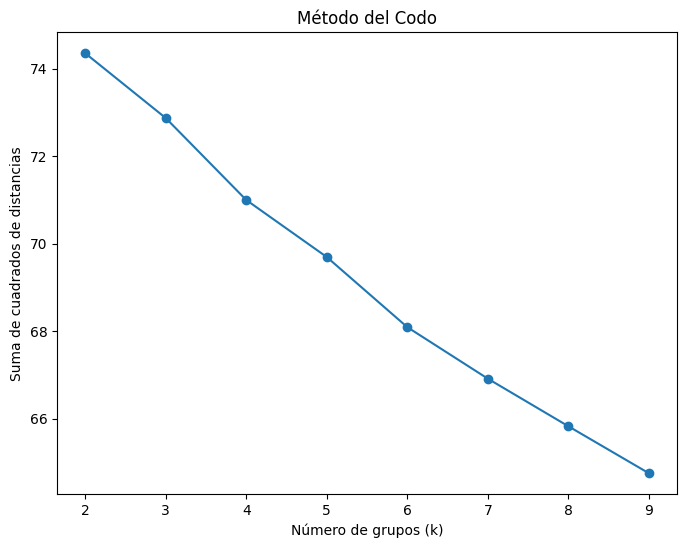

In [10]:
distortions = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_matrix)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), distortions, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de grupos (k)')
plt.ylabel('Suma de cuadrados de distancias')
plt.show()

In [19]:
# Create a KMeans object with 5 clusters and save as km
km = KMeans(n_clusters=5)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
movies_df["cluster"] = clusters

# Display number of films per cluster (clusters from 0 to 4)
movies_df['cluster'].value_counts()

/home/jhonjc/anaconda3/envs/quimica/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


3    40
2    21
0    18
1    15
4     6
Name: cluster, dtype: int64

In [20]:
movies_df.head(7)

,rank,title,genre,wiki_plot,imdb_plot,plot,cluster
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit...",0
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","In 1947, banker Andy Dufresne is convicted of ...",3
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"In 1939, the Germans move Polish Jews into the...",2
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight...",0
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...",It is early December 1941. American expatriate...,3
5,5,One Flew Over the Cuckoo's Nest,[u' Drama'],"In 1963 Oregon, Randle Patrick ""Mac"" McMurphy ...","In 1963 Oregon, Randle Patrick McMurphy (Nicho...","In 1963 Oregon, Randle Patrick ""Mac"" McMurphy ...",3
6,6,Gone with the Wind,"[u' Drama', u' Romance', u' War']",\nPart 1\n \n Part 1 Part 1 \n \n On the...,"The film opens in Tara, a cotton plantation ow...",\nPart 1\n \n Part 1 Part 1 \n \n On the...,1


In [27]:
def recommend_similar_movies(movie_reference, movies_df):
    reference_movie = movies_df[movies_df["title"] == movie_reference]
    
    reference_cluster = reference_movie['cluster'].values[0]
    
    cluster_movies = movies_df[movies_df['cluster'] == reference_cluster]
    
    cluster_movie_indices = cluster_movies.index
    
    similarity_scores = cosine_similarity(tfidf_matrix[reference_movie.index], tfidf_matrix[cluster_movie_indices])
    
    similar_movies_indices = np.argsort(similarity_scores)[0][::-1]
    
    similar_movies_indices = similar_movies_indices[similar_movies_indices != 0]
    
    top_similar_movie_titles = cluster_movies.loc[cluster_movie_indices[similar_movies_indices[1:6]]]["title"]
    
    recommended_movies_df = pd.DataFrame({'Recommended Movies': top_similar_movie_titles})
    recommended_movies_df["Ranking"] = list(range(1,6))
    return recommended_movies_df


In [28]:
movie_reference = "Braveheart"

recommended_movies = recommend_similar_movies(movie_reference, movies_df)

print(f"5 películas recomendadas para '{movie_reference}' dentro del mismo clúster:")
recommended_movies

5 películas recomendadas para 'Braveheart' dentro del mismo clúster:


,Recommended Movies,Ranking
34,Gladiator,1
33,The Lord of the Rings: The Return of the King,2
57,Dances with Wolves,3
48,Patton,4
36,Saving Private Ryan,5
